In [1]:
!nvidia-smi

Sun May 10 15:48:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

In [3]:
print(tf.__version__)
print(keras.__version__)

2.2.0-rc4
2.3.0-tf


## Data 준비

In [4]:
## google drive에서 압축된 dataset download
import gdown
url = 'https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0'
fname = 'oxford_pet.zip'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0
To: /content/oxford_pet.zip
811MB [00:29, 27.3MB/s]


'oxford_pet.zip'

In [5]:
## oxford_pet.zip이 보이는지 확인
!ls -l

total 791576
-rw-r--r-- 1 root root 810565619 May 10 15:49 oxford_pet.zip
drwxr-xr-x 1 root root      4096 May  4 16:26 sample_data


In [0]:
## 압축풀기
!unzip -q oxford_pet.zip -d oxford_pet

In [7]:
## 압축이 풀린 directory 확인
!ls oxford_pet

annotations  images


In [0]:
## directory 설정
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'oxford_pet')
image_dir = os.path.join(data_dir, 'images')

In [9]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7390


In [10]:
## image file들을 읽어서 channel이 3이 아닌 image는 삭제
for image_file in image_files:
  image_path = os.path.join(image_dir, image_file)
  image = Image.open(image_path)
  image_mode = image.mode
  if image_mode != 'RGB':
    print(image_file, image_mode)
    image = np.asarray(image)
    print(image.shape)
    os.remove(image_path)

Egyptian_Mau_186.jpg RGBA
(275, 183, 4)
Egyptian_Mau_167.jpg P
(275, 183)
Egyptian_Mau_14.jpg RGBA
(800, 582, 4)
Abyssinian_5.jpg RGBA
(150, 200, 4)
Egyptian_Mau_129.jpg L
(325, 299)
staffordshire_bull_terrier_22.jpg L
(500, 364)
Egyptian_Mau_177.jpg P
(175, 246)
staffordshire_bull_terrier_2.jpg L
(282, 500)
Egyptian_Mau_139.jpg P
(250, 350)
Egyptian_Mau_191.jpg P
(214, 300)
Egyptian_Mau_145.jpg P
(188, 216)
Abyssinian_34.jpg P
(202, 250)


In [11]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7378


In [12]:
class_list = set()
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+', '', file_name)
    class_list.add(class_name)
class_list = list(class_list)
print(len(class_list))

37


In [13]:
class_list.sort()
class_list

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [14]:
class_list[1]

'Bengal'

In [15]:
class2idx = {cls:idx for idx, cls in enumerate(class_list)}
class2idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [16]:
class2idx['Bengal']

1

In [0]:
## train, validation directory 생성
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [0]:
image_files.sort()

In [19]:
image_files[:10]

['Abyssinian_1.jpg',
 'Abyssinian_10.jpg',
 'Abyssinian_100.jpg',
 'Abyssinian_101.jpg',
 'Abyssinian_102.jpg',
 'Abyssinian_103.jpg',
 'Abyssinian_104.jpg',
 'Abyssinian_105.jpg',
 'Abyssinian_106.jpg',
 'Abyssinian_107.jpg']

In [0]:
cnt = 0
previous_class = ""
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+', '', file_name)
    if class_name == previous_class:
        cnt += 1
    else:
        cnt = 1
    if cnt <= 160:
        cpath = train_dir
    else:
        cpath = val_dir
    image_path = os.path.join(image_dir, image_file)
    shutil.copy(image_path, cpath)
    previous_class = class_name

In [0]:
train_images = os.listdir(train_dir)
val_images = os.listdir(val_dir)

In [22]:
print(len(train_images), len(val_images))

5920 1458


In [23]:
train_images[:10]

['boxer_167.jpg',
 'Bengal_176.jpg',
 'pomeranian_168.jpg',
 'Egyptian_Mau_124.jpg',
 'British_Shorthair_134.jpg',
 'staffordshire_bull_terrier_158.jpg',
 'beagle_174.jpg',
 'Siamese_159.jpg',
 'newfoundland_105.jpg',
 'japanese_chin_192.jpg']

In [24]:
val_images[:10]

['english_cocker_spaniel_80.jpg',
 'Ragdoll_99.jpg',
 'english_cocker_spaniel_63.jpg',
 'British_Shorthair_97.jpg',
 'samoyed_78.jpg',
 'Bombay_95.jpg',
 'Birman_74.jpg',
 'Bengal_68.jpg',
 'pomeranian_88.jpg',
 'samoyed_76.jpg']

## TFRecord File 만들기

In [0]:
IMG_SIZE = 224

In [0]:
## TFRecord 저장할 directory와 file 경로 설정
tfr_dir = os.path.join(data_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'cls_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'cls_val.tfr')

In [0]:
## TFRecord writer 생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [0]:
with tf.io.TFRecordWriter('test.tfr') as f:
  f.write(b"This is the first record")
  f.write(b"This is the second record")
  f.write(b"This is the third record")
  f.write(b"This is the fourth record")

In [29]:
temp_ds = tf.data.TFRecordDataset('test.tfr')
temp_ds = temp_ds.shuffle(4).batch(2).repeat(3)
for data in temp_ds:
  print(data)

tf.Tensor([b'This is the third record' b'This is the fourth record'], shape=(2,), dtype=string)
tf.Tensor([b'This is the first record' b'This is the second record'], shape=(2,), dtype=string)
tf.Tensor([b'This is the second record' b'This is the fourth record'], shape=(2,), dtype=string)
tf.Tensor([b'This is the third record' b'This is the first record'], shape=(2,), dtype=string)
tf.Tensor([b'This is the first record' b'This is the third record'], shape=(2,), dtype=string)
tf.Tensor([b'This is the second record' b'This is the fourth record'], shape=(2,), dtype=string)


In [0]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [31]:
n_train = 0

train_files = os.listdir(train_dir)
for train_file in train_files:
  train_path = os.path.join(train_dir, train_file)
  image = Image.open(train_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  file_name = os.path.splitext(train_file)[0] #Bangal_101
  class_name = re.sub('_\d+', '', file_name)
  class_num = class2idx[class_name]

  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num)
  }))
  writer_train.write(example.SerializeToString())
  n_train += 1

writer_train.close()
print(n_train)

5920


In [32]:
n_val = 0

val_files = os.listdir(val_dir)
for val_file in val_files:
  val_path = os.path.join(val_dir, val_file)
  image = Image.open(val_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  file_name = os.path.splitext(val_file)[0] #Bangal_101
  class_name = re.sub('_\d+', '', file_name)
  class_num = class2idx[class_name]

  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num)
  }))
  writer_val.write(example.SerializeToString())
  n_val += 1

writer_val.close()
print(n_val)

1458


In [33]:
!ls -l $tfr_dir

total 1085020
-rw-r--r-- 1 root root 891486880 May 10 15:51 cls_train.tfr
-rw-r--r-- 1 root root 219558762 May 10 15:51 cls_val.tfr


## Classification

In [0]:
## Hyper Parameters
N_CLASS = len(class_list)
N_EPOCHS = 20
N_BATCH = 40
N_TRAIN = n_train
N_VAL = n_val
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [0]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64)              
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255. 

    label = tf.cast(parsed_features['cls_num'], tf.int64)

    return image, label

In [0]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [0]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

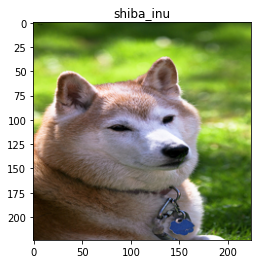

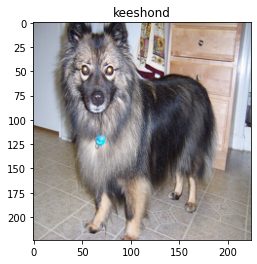

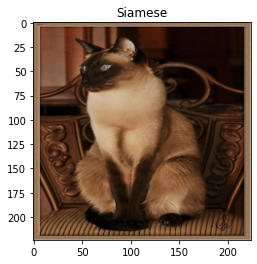

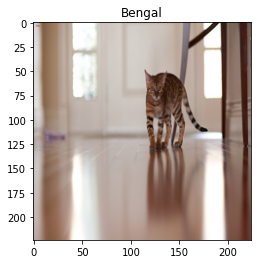

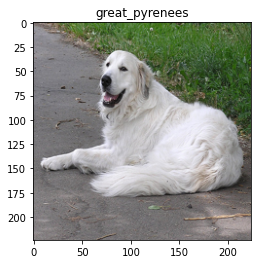

In [49]:
for image, label in train_dataset.take(5):
  plt.imshow(image[0])
  title = class_list[label[0].numpy()]
  plt.title(title)
  plt.show()

In [0]:
# Sequential API를 사용하여 model 구성
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='SAME', 
                                  input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(N_CLASS, activation='softmax'))
    return model

In [42]:
## Create model, compile & summary
model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 256)      

In [43]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/20
148/148 [==============================] - 9s 58ms/step - loss: 3.5865 - accuracy: 0.0402 - val_loss: 3.4732 - val_accuracy: 0.0727
Epoch 2/20
148/148 [==============================] - 8s 56ms/step - loss: 3.2942 - accuracy: 0.1083 - val_loss: 3.1422 - val_accuracy: 0.1454
Epoch 3/20
148/148 [==============================] - 8s 56ms/step - loss: 3.0164 - accuracy: 0.1760 - val_loss: 2.9321 - val_accuracy: 0.1804
Epoch 4/20
148/148 [==============================] - 8s 56ms/step - loss: 2.7924 - accuracy: 0.2174 - val_loss: 2.8381 - val_accuracy: 0.1975
Epoch 5/20
148/148 [==============================] - 8s 56ms/step - loss: 2.5822 - accuracy: 0.2779 - val_loss: 2.7634 - val_accuracy: 0.2209
Epoch 6/20
148/148 [==============================] - 8s 56ms/step - loss: 2.3614 - accuracy: 0.3260 - val_loss: 2.6988 - val_accuracy: 0.2531
Epoch 7/20
148/148 [==============================] - 8s 56ms/step - loss: 2.1031 - accuracy: 0.3970 - val_loss: 2.6442 - val_accuracy: 0.2661

In [0]:
# Sequential API를 사용하여 model 구성
def create_bn_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='SAME', 
                                  input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())    
    model.add(keras.layers.Dense(N_CLASS, activation='softmax'))
    return model

In [47]:
## Create model, compile & summary
model = create_bn_model()

## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*5,
                                                          decay_rate=0.5,
                                                          staircase=True)
model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_11 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
re_lu_11 (ReLU)              (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_12 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_12 (ReLU)              (None, 112, 112, 64)     

In [48]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/20
148/148 [==============================] - 10s 69ms/step - loss: 3.1893 - accuracy: 0.1682 - val_loss: 5.1815 - val_accuracy: 0.0309
Epoch 2/20
148/148 [==============================] - 10s 68ms/step - loss: 1.6241 - accuracy: 0.5872 - val_loss: 5.6648 - val_accuracy: 0.0364
Epoch 3/20
148/148 [==============================] - 10s 68ms/step - loss: 0.6402 - accuracy: 0.9084 - val_loss: 4.1818 - val_accuracy: 0.0734
Epoch 4/20
148/148 [==============================] - 10s 68ms/step - loss: 0.1899 - accuracy: 0.9944 - val_loss: 3.0115 - val_accuracy: 0.2092
Epoch 5/20
148/148 [==============================] - 10s 68ms/step - loss: 0.0736 - accuracy: 0.9998 - val_loss: 2.6411 - val_accuracy: 0.2860
Epoch 6/20
148/148 [==============================] - 10s 68ms/step - loss: 0.0401 - accuracy: 1.0000 - val_loss: 2.5964 - val_accuracy: 0.3032
Epoch 7/20
148/148 [==============================] - 10s 68ms/step - loss: 0.0323 - accuracy: 1.0000 - val_loss: 2.6075 - val_accuracy:

In [49]:
## Create model, compile & summary
model = create_bn_model()

LR_INIT = 0.000001
LR_MAX = 0.001
LR_MIN = LR_INIT
RAMPUP_EPOCH = 2
EXP_DECAY = 0.8

def lr_schedule_fn(epoch):
  if epoch < RAMPUP_EPOCH:
    lr = (LR_MAX - LR_MIN) / RAMPUP_EPOCH * epoch + LR_INIT
  else:
    lr = (LR_MAX - LR_MIN) * EXP_DECAY**(epoch - RAMPUP_EPOCH)
  return lr

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule_fn)

model.compile(optimizer=tf.keras.optimizers.Adam(LR_INIT),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_17 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
re_lu_17 (ReLU)              (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_18 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_18 (ReLU)              (None, 112, 112, 64)     

In [50]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[lr_callback]
)

Epoch 1/20
148/148 [==============================] - 10s 69ms/step - loss: 3.9526 - accuracy: 0.0265 - val_loss: 3.8482 - val_accuracy: 0.0274 - lr: 1.0000e-06
Epoch 2/20
148/148 [==============================] - 10s 67ms/step - loss: 3.0406 - accuracy: 0.1981 - val_loss: 6.2067 - val_accuracy: 0.0473 - lr: 5.0050e-04
Epoch 3/20
148/148 [==============================] - 10s 68ms/step - loss: 2.2843 - accuracy: 0.3644 - val_loss: 5.7278 - val_accuracy: 0.0796 - lr: 9.9900e-04
Epoch 4/20
148/148 [==============================] - 10s 68ms/step - loss: 1.1329 - accuracy: 0.6785 - val_loss: 5.2928 - val_accuracy: 0.0816 - lr: 7.9920e-04
Epoch 5/20
148/148 [==============================] - 10s 68ms/step - loss: 0.3197 - accuracy: 0.9356 - val_loss: 2.8299 - val_accuracy: 0.2798 - lr: 6.3936e-04
Epoch 6/20
148/148 [==============================] - 10s 68ms/step - loss: 0.0580 - accuracy: 0.9978 - val_loss: 2.6093 - val_accuracy: 0.3285 - lr: 5.1149e-04
Epoch 7/20
148/148 [==============

In [0]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255. 

    label = tf.cast(parsed_features['cls_num'], tf.int64)
    label = tf.one_hot(label, N_CLASS)

    return image, label

In [0]:
def cutmix(images, labels, PROB=0.5):
  print(images.shape, labels.shape)
  imgs = []; labs = []
  for i in range(N_BATCH):
    APPLY = tf.cast(tf.random.uniform(()) <= PROB, tf.int32)
    idx = tf.random.uniform((), 0, N_BATCH, tf.int32)

    W = IMG_SIZE; H = IMG_SIZE
    lam = tf.random.uniform(())
    cut_ratio = tf.math.sqrt(1.-lam)    
    cut_w = tf.cast(W * cut_ratio, tf.int32) * APPLY
    cut_h = tf.cast(H * cut_ratio, tf.int32) * APPLY

    cx = tf.random.uniform((), 0, W, tf.int32)
    cy = tf.random.uniform((), 0, H, tf.int32)

    xmin = tf.clip_by_value(cx - cut_w//2, 0, W)
    ymin = tf.clip_by_value(cy - cut_h//2, 0, H)
    xmax = tf.clip_by_value(cx + cut_w//2, 0, W)
    ymax = tf.clip_by_value(cy + cut_h//2, 0, H)    
    
    mid_left = images[i, ymin:ymax, :xmin, :]
    mid_mid = images[idx, ymin:ymax, xmin:xmax, :]
    mid_right = images[i, ymin:ymax, xmax:, :]
    middle = tf.concat([mid_left, mid_mid, mid_right], axis=1)
    top = images[i, :ymin, :, :]
    bottom = images[i, ymax:, :, :]
    new_img = tf.concat([top, middle, bottom], axis=0)
    imgs.append(new_img)
    
    alpha = tf.cast((cut_w*cut_h)/(W*H), tf.float32)
    label1 = labels[i]; label2 = labels[idx]
    new_label = ((1-alpha)*label1 + alpha*label2)
    labs.append(new_label)

  new_imgs = tf.reshape(tf.stack(imgs), [-1, IMG_SIZE, IMG_SIZE, 3])
  new_labs = tf.reshape(tf.stack(labs), [-1, N_CLASS])

  return new_imgs, new_labs

In [56]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH)
train_dataset = train_dataset.map(cutmix).repeat()

(None, 224, 224, 3) (None, 37)
(None, 224, 224, 3) (40, 37)


In [0]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

In [61]:
for image, label in train_dataset.take(1):
  for i in range(N_BATCH):    
    print(label[i].numpy())
    plt.imshow(image[i])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [62]:
## Create model, compile & summary
model = create_bn_model()

LR_INIT = 0.000001
LR_MAX = 0.001
LR_MIN = LR_INIT
RAMPUP_EPOCH = 2
EXP_DECAY = 0.9

def lr_schedule_fn(epoch):
  if epoch < RAMPUP_EPOCH:
    lr = (LR_MAX - LR_MIN) / RAMPUP_EPOCH * epoch + LR_INIT
  else:
    lr = (LR_MAX - LR_MIN) * EXP_DECAY**(epoch - RAMPUP_EPOCH)
  return lr

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule_fn)

model.compile(optimizer=tf.keras.optimizers.Adam(LR_INIT),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_23 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
re_lu_23 (ReLU)              (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_24 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_24 (ReLU)              (None, 112, 112, 64)     

In [63]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS+30,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[lr_callback]
)

Epoch 1/50
148/148 [==============================] - 13s 86ms/step - loss: 4.0460 - accuracy: 0.0248 - val_loss: 3.7735 - val_accuracy: 0.0281 - lr: 1.0000e-06
Epoch 2/50
148/148 [==============================] - 12s 84ms/step - loss: 3.3667 - accuracy: 0.1405 - val_loss: 6.6716 - val_accuracy: 0.0274 - lr: 5.0050e-04
Epoch 3/50
148/148 [==============================] - 12s 84ms/step - loss: 3.0355 - accuracy: 0.2111 - val_loss: 5.7035 - val_accuracy: 0.0508 - lr: 9.9900e-04
Epoch 4/50
148/148 [==============================] - 12s 84ms/step - loss: 2.5345 - accuracy: 0.3463 - val_loss: 3.8122 - val_accuracy: 0.1694 - lr: 8.9910e-04
Epoch 5/50
148/148 [==============================] - 12s 84ms/step - loss: 2.0621 - accuracy: 0.4875 - val_loss: 3.0230 - val_accuracy: 0.2339 - lr: 8.0919e-04
Epoch 6/50
148/148 [==============================] - 12s 84ms/step - loss: 1.6807 - accuracy: 0.6090 - val_loss: 3.2139 - val_accuracy: 0.2119 - lr: 7.2827e-04
Epoch 7/50
148/148 [==============

In [0]:
keras.backend.clear_session()